## Imports

In [1]:
import boto3
import graphs
import numpy                 as np
import pandas                as pd
import matplotlib.pyplot     as plt
import seaborn               as sns
from metrics                 import confusion_matrix_dataframe, ternary_classification_summary 
from sklearn.metrics         import balanced_accuracy_score, matthews_corrcoef, jaccard_score
from sklearn.model_selection import train_test_split
from keras                   import regularizers
from keras.models            import Sequential
from keras.layers            import Dense, Flatten, Dropout
from keras.layers            import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils             import np_utils
from keras.callbacks         import EarlyStopping, ModelCheckpoint
from IPython.core.display    import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# Declaring a random state for the modeling process

np.random.seed(42)

Using TensorFlow backend.


## Table Of Contents
     
 
- [Reading In The New Data](#Reading-In-The-New-Data)
    - [Data Overview](#Data-Overview)
    - [Mapping Labels](#Mapping-Labels)
    
    
- [Preprocessing](#Preprocessing)
    - [Declaring X and y](#Declaring-X-and-y)    
    - [Train-Test Splitting The Data](#Train-Test-Splitting-The-Data)
    - [Reshaping The Data](#Reshaping-The-Data)
    
    
- [Modeling](#Modeling)
    - [Setting Up The Neural Network](#Setting-Up-The-Neural-Network)
    - [Compiling The Neural Network](#Compiling-The-Neural-Network)
    - [Fitting The Training Data](#Fitting-The-Training-Data)
    - [Generating Predictions](#Generating-Predictions)
 
 
- [Evaluation](#Evaluation)
    - [Metrics](#Metrics)
        - [Train](#Train)
        - [Test](#Test)
    - [Confusion Matrix](#Confusion-Matrix)
    - [Graphs](#Graphs)
        - [Model History](#Model-History)
            - [Loss](#Loss)
            - [Accuracy](#Accuracy)
        - [Metrics](#Metrics)

## Reading In The Data

In [2]:
# Reading in my credentials

with open("access_key", "r") as key:
    access_key = key.read()
    
with open("secret_key", "r") as secret:
    secret_access_key = secret.read()
    
# Setting up my s3 bucket as the client instance
    
client = boto3.client("s3", 
                      aws_access_key_id     = access_key,
                      aws_secret_access_key = secret_access_key)

# Naming the bucket and file

bucket_name = "google-quick-draw"
object_key  = "animals.csv"

# Creating a csv object

csv_obj = client.get_object(Bucket = bucket_name, 
                            Key    = object_key)

body    = csv_obj["Body"]

# Reading in the data

animals = pd.read_csv(body)

### Data Overview

In [3]:
# Checking the dimensions of the dataframe

animals.shape

(410123, 785)

In [4]:
# Looking at the head five rows

animals.head()

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,bear,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,bear,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,bear,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,bear,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,bear,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
animals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410123 entries, 0 to 410122
Columns: 785 entries, label to 783
dtypes: int64(784), object(1)
memory usage: 2.4+ GB


In [6]:
# Looking for null values

animals.isnull().sum().sum()

0

### Mapping Labels

Our labels are strings, but we need them to be integers for modeling.  To make them strings, we will use a simple `.replace()` to change them in place.

In [7]:
animals["label"].replace(to_replace = {"bear": 0,
                                       "cat" : 1,
                                       "dog" : 2},
                         inplace    = True)

# Making sure the labels are integers

animals["label"].dtype

dtype('int64')

[Top](#Table-Of-Contents)

## Preprocessing

### Declaring X and y

In [8]:
# X variable

X = np.array(animals.drop(columns = "label")) 

# y variable

y = animals["label"].values

### Train-Test Splitting The Data

In [9]:
# We are setting a random state for reproducability

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state = 42, 
                                                    test_size    = 0.3)

# Keeping copies of the original labels

y_train_org = y_train

y_test_org  = y_test

In [10]:
# Scaling each X value

X_train = X_train.astype(float)
X_train /= 255

X_test  = X_test.astype(float)
X_test  /= 255

# Making sure the y variables are categorical

y_train = np_utils.to_categorical(y_train, 3)

y_test  = np_utils.to_categorical(y_test, 3)

### Reshaping The Data

In [11]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

X_test  = X_test.reshape(X_test.shape[0], 28, 28, 1)

# Checking the data type of the train and test sets

print(f"X_train's data type is {type(X_train)}")

print(f"X_test's data type is {type(X_test)}")

X_train's data type is <class 'numpy.ndarray'>
X_test's data type is <class 'numpy.ndarray'>


[Top](#Table-Of-Contents)

## Modeling

### Setting Up The Neural Network

#### Instantiating The Model

In [26]:
cnn = Sequential()

#### Adding Layers

The first portion of our convolutional neural network is composed of two types of layers: convolutional and maxpooling layers.


- Convolutional layers are what set convolutional neural networks apart from a feed-forward or recurrent neural network.  The convolutional componant uses a linear operation to reduce a full image into a feature map.


- Maxpooling down-samples the output from the convolution into smaller (usually non-overlapping) grids and takes the highest value from each grid.

In [27]:
# Convolutional layers

# The first convolutional layer

cnn.add(Conv2D(filters     = 7,
               kernel_size = 4,
               activation  = "relu",
               input_shape = (28,28,1)))

# The first maxpooling layer

cnn.add(MaxPooling2D(pool_size = (2,2)))

# The second convolutional layer

cnn.add(Conv2D(128,
               kernel_size = 4,
               activation  = "relu"))

# The second maxpooling layer

cnn.add(MaxPooling2D(pool_size = (2,2)))


The second portion of our neural network is a little more complicated: it incorporates flattening, dense layers, batch normalization, and dropout.


- Flattening simply decomposes the processed images into a format that can be passed into the dense layers.


- Dense here are the same as in any other neural network.  Each node here contains $\ell$<sub>2</sub> regularization to help reduce overfitting.


- Batch normalization is a normlization method to reduce the shifting of outputs from each hidden layer.


- Dropout is another regularizaton technique that helps reduce overfitting by ignoring the output from a certain number of neurons.

In [28]:
# Dense layers

# Flattening the data

cnn.add(Flatten())

# Adding the first dense layer

cnn.add(Dense(128,
              activation         = "relu",
              kernel_regularizer = regularizers.l2(0.001)))

# Adding batch normalization

cnn.add(BatchNormalization())

# Adding the first dropout

cnn.add(Dropout(rate = 0.8))

# Adding the second dense layer

cnn.add(Dense(64,
              activation         = "relu",
              kernel_regularizer = regularizers.l2(0.001)))

# Adding batch normalization

cnn.add(BatchNormalization())
                
# Adding second dropout

cnn.add(Dropout(rate = 0.8))

# Adding the ouput layer

cnn.add(Dense(3,
              activation = "softmax"))

W1101 21:55:49.594726 140301323372352 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1101 21:55:49.707670 140301323372352 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


[Top](#Table-Of-Contents)

### Compiling The Neural Network

In [29]:
cnn.compile(loss      = "categorical_crossentropy",
            optimizer = "adam",
            metrics   = ["acc"])

### Fitting The Training Data

We decided to add a third regularization technique to our model: early stopping.

Early stopping allows us to run our model for the number of epochs we want, but it will stop training once it detects that performance is not improving.

In [30]:
# Defining our callback

callback = [EarlyStopping(monitor  = "val_loss", 
                          patience = 1,
                          verbose  = 0)]

In [31]:
history = cnn.fit(X_train,
                  y_train,
                  callbacks       = callback,
                  validation_data = (X_train, y_train),
                  batch_size      = 512,
                  epochs          = 75,
                  verbose         = 0)

### Generating Predictions

In [32]:
# Training predictions

train_preds = cnn.predict_classes(X_train,
                                  batch_size = 256,
                                  verbose    = 0).ravel()

# Test predictions

test_preds = cnn.predict_classes(X_test,
                                 batch_size = 256,
                                 verbose    = 0).ravel()

## Evaluation

We decided to use five metrics to evaluate our model's perofrmance:


| Metric                               | Definition                                                                                     | Scale   |
|:-------------------------------------|:-----------------------------------------------------------------------------------------------|:-------:|
| **Balanced Accuracy**                | Average of the recall (percentage of correct positives) for each class                         | 0 to 1  |
| **Specificity**                      | Average of the percentage of correct negatives for each class                                  | 0 to 1  |
| **Matthews Correlation Coefficient** | Measure of a classifier's quality: measures the correlation between actual & predicted labels  | -1 to 1 |
| **Jaccard Score**                    | A measure  of how often each class appears in each set                                         | 0 to 1  |

### Metrics

#### Train

In [33]:
ternary_classification_summary(y_train_org, train_preds)

,Score
Balanced Accuracy,0.827038
Specificity,0.826692
Matthews Corr. Coef.,0.744490
Jaccard Score,0.710571


#### Test

In [34]:
ternary_classification_summary(y_test_org, test_preds)

,Score
Balanced Accuracy,0.820304
Specificity,0.818116
Matthews Corr. Coef.,0.734533
Jaccard Score,0.700757


In [35]:
# Saving a copy of the test dataframe to plot

scores = ternary_classification_summary(y_test_org, test_preds)*100

### Confusion Matrix

In [36]:
confusion_matrix_dataframe(y_test_org,
                           test_preds,
                           columns = ["Bear", "Cat", "Dog"],
                           index   = ["Bear", "Cat", "Dog"])

,Bear,Cat,Dog
Bear,34924,715,4718
Cat,3025,28195,5977
Dog,5881,1508,38094


### Graphs

#### Loss

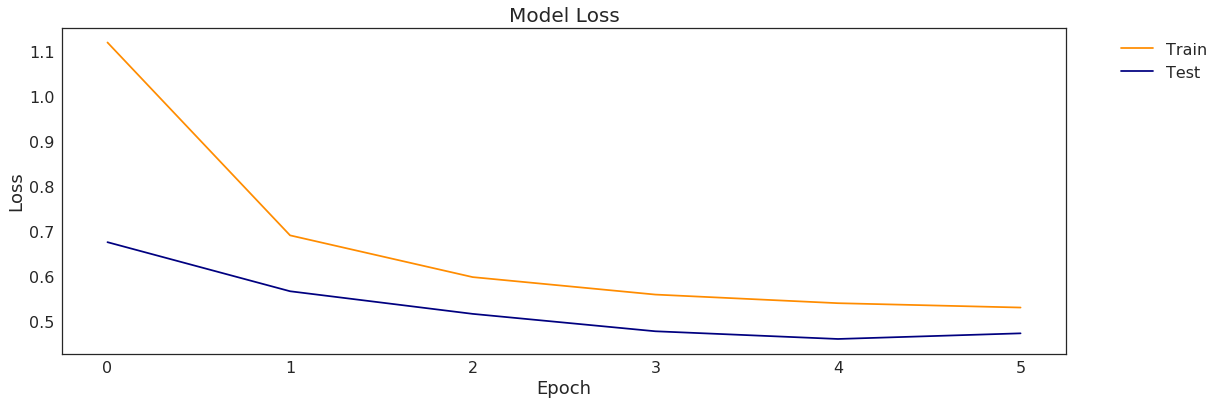

In [37]:
plt.figure(figsize = (18,6), facecolor = "white")
plt.plot(history.history['loss'], label = 'Train Loss', color = "darkorange")
plt.plot(history.history['val_loss'], label = 'Val. Loss', color = "navy")
plt.title("Model Loss", size = 20)
plt.xlabel("Epoch", size = 18)
plt.ylabel("Loss", size = 18)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.legend(["Train", "Test"],bbox_to_anchor = (1.04, 1), loc = "upper left", fontsize = 16);

#### Accuracy

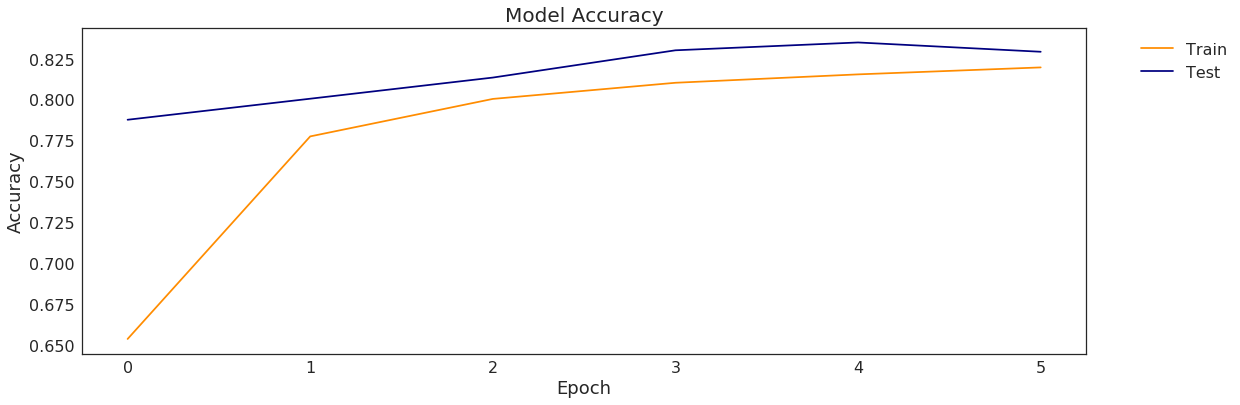

In [38]:
plt.figure(figsize = (18,6), facecolor = "white")
plt.plot(history.history['acc'], label = 'Train Acc', color = "darkorange")
plt.plot(history.history['val_acc'], label = 'Val. Acc.', color = "navy")
plt.title("Model Accuracy", size = 20)
plt.xlabel("Epoch", size = 18)
plt.ylabel("Accuracy", size = 18)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.legend(["Train", "Test"], bbox_to_anchor = (1.04, 1), loc = "upper left", fontsize = 16);

### Metrics

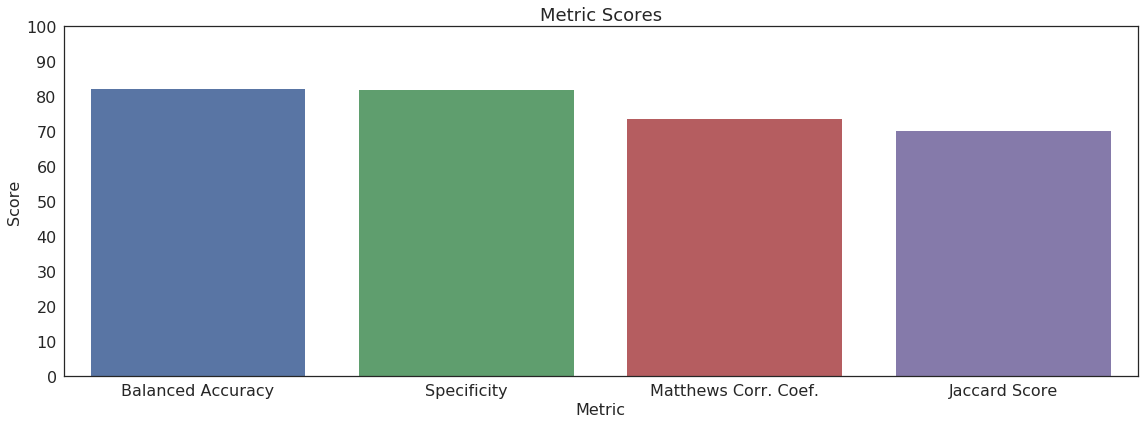

In [39]:
graphs.barplot(df     = scores,
               x      = scores.index,
               y      = "Score",
               title  =  "Metric Scores",
               label  =  "Metric",
               ylabel = "Score",
               yticks = np.arange(0, 110, 10),
               dim    = (16,6))

[Top](#Table-Of-Contents)